In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime

from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.utils import algorithm_globals
from functions import *

Parameter, Data retrieval, Normalization and Creation of the QUBO problem

In [2]:
p = 3
n = 10
q = 0.5
budget = n//2
penalty = n

# Fetch and prepare data
tickers = get_famous_tickers(n)
print("Selected Tickers:", tickers)
mu, sigma, data = get_portfolio_data(tickers=tickers, start_date="2016-01-01", end_date="2016-12-30", num_assets=n)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program
qp_realdata, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q=q, budget=budget)


c:\Users\andre\OneDrive\Ambiente de Trabalho\qc803-QAOAFinal\src\PortfolioOptimization_QAOA\functions.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[                       0%                       ]

Selected Tickers: ['JNJ', 'COST', 'V', 'INTC', 'UNH', 'NVDA', 'TSLA', 'GS', 'MA', 'PG']


[*********************100%***********************]  10 of 10 completed

1 Failed download:
['V']: OperationalError('database is locked')
c:\Users\andre\OneDrive\Ambiente de Trabalho\qc803-QAOAFinal\src\PortfolioOptimization_QAOA\functions.py:69: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change().dropna()
c:\Users\andre\OneDrive\Ambiente de Trabalho\qc803-QAOAFinal\venv\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\andre\OneDrive\Ambiente de Trabalho\qc803-QAOAFinal\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\andre\OneDrive\Ambiente de Trabalho\qc803-QAOAFinal\venv\Lib\site-packages\pa

DOcplexException: Expecting valid float number, got: nan

Testing different optmizers for the same problem and comparing them with the greedy algorithm

Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0381
SPSA       | 0.9355   | -0.1280     | 1101010010  | 0.0000
POWELL     | 1.0000   | -0.2522     | 1001011010  | 0.0312

Greedy Solver Results:
Selection: 0101011010, Value: -0.2280, Ratio: 0.9874


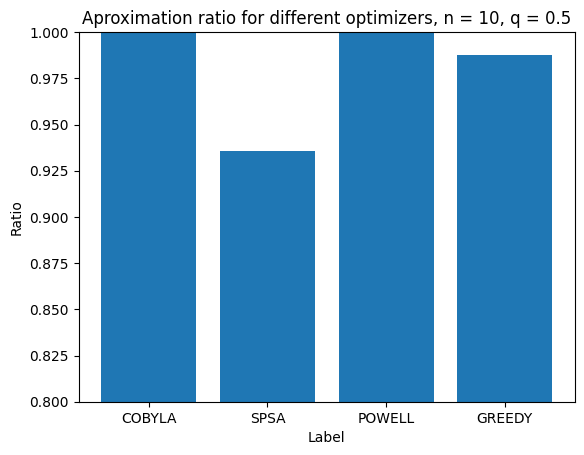

In [ ]:
# Run QAOA Experiments (test different optimizers)
iter=200
optimizers_to_test = {
        "COBYLA": COBYLA(maxiter=iter),
        "SPSA": SPSA(maxiter=iter),
        "POWELL": POWELL(maxiter=iter)
}

results_data = run_qaoa_experiments(qp=qp_realdata, penalty=penalty, reps=p, optimizers_to_test=optimizers_to_test,mu=mu_normalized, sigma=sigma_normalized, q=q, budget=budget)

# Greedy Solver
x, value, selection_str = solve_greedy(mu_normalized, sigma_normalized, budget, qp_realdata)
greedyr = get_aproximation_ratio(x, mu_normalized, sigma_normalized, q, budget,greedy=True,energy=value)
results_data["GREEDY"] = {
    "probs": {selection_str: 1.0},  # Greedy is deterministic
    "optimal_str": selection_str,
    "optimal_val": value,
    "ratio": greedyr 
}

# Print Greedy Results
print("\nGreedy Solver Results:")
print(f"Selection: {selection_str}, Value: {value:.4f}, Ratio: {greedyr:.4f}")

# Plot QAOA Results
labels = list(results_data.keys())
ratios = [results_data[label]["ratio"] for label in labels]

plt.bar(labels, ratios)
plt.ylabel("Ratio")
plt.xlabel("Label")
plt.title(f"Aproximation ratio for different optimizers, n = {n}, q = {q}")
plt.ylim(0.8, 1)
plt.show()

Varying the number of iterations for each optimizer

In [ ]:
# Run QAOA experiments for different optimizer iteration counts
iter_values = [1, 5, 10, 50, 100, 200, 300, 500]
results_by_iter = {}

for it in iter_values:
    print(f"\n{'='*60}")
    print(f"Running QAOA with optimizer maxiter={it}")
    print(f"{'='*60}")
    
    opt_for_iter = {
        "COBYLA": COBYLA(maxiter=it),
        "SPSA": SPSA(maxiter=it),
        "POWELL": POWELL(maxiter=it)
    }
    
    results_by_iter[it] = run_qaoa_experiments(
        qp=qp_realdata,
        penalty=penalty,
        reps=p,
        optimizers_to_test=opt_for_iter,
        mu=mu_normalized,
        sigma=sigma_normalized,
        q=q,
        budget=budget
    )

# Display summary of approximation ratios across all iteration counts
print(f"\n{'='*60}")
print("Summary: Approximation Ratios by Optimizer Iterations")
print(f"{'='*60}")
print(f"{'Iter':<6} | {'COBYLA':<10} | {'SPSA':<10} | {'POWELL':<10}")
print("-" * 50)

for it in iter_values:
    cobyla_ratio = results_by_iter[it]["COBYLA"]["ratio"]
    spsa_ratio = results_by_iter[it]["SPSA"]["ratio"]
    powell_ratio = results_by_iter[it]["POWELL"]["ratio"]
    print(f"{it:<6} | {cobyla_ratio:<10.4f} | {spsa_ratio:<10.4f} | {powell_ratio:<10.4f}")


Running QAOA with optimizer maxiter=1
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------


c:\Users\andre\OneDrive\Ambiente de Trabalho\qc803-QAOAFinal\venv\Lib\site-packages\scipy\_lib\pyprima\common\preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 8
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0186
SPSA       | 1.0000   | -0.2522     | 1001011010  | 0.0010
POWELL     | 1.0000   | -0.2522     | 1001011010  | 0.0352

Running QAOA with optimizer maxiter=5
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------


c:\Users\andre\OneDrive\Ambiente de Trabalho\qc803-QAOAFinal\venv\Lib\site-packages\scipy\_lib\pyprima\common\preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 8
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0186
SPSA       | 1.0000   | -0.2522     | 1001011010  | 0.0068
POWELL     | 1.0000   | -0.2522     | 1001011010  | 0.0312

Running QAOA with optimizer maxiter=10
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0186
SPSA       | 1.0000   | -0.2522     | 1001011010  | 0.0010
POWELL     | 1.0000   | -0.2522     | 1001011010  | 0.0312

Running QAOA with optimizer maxiter=50
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0381
SPSA       | 1.0000   | -0.2522     | 1001011010  | 0.0020
POWELL     | 1.0000   | -0.252

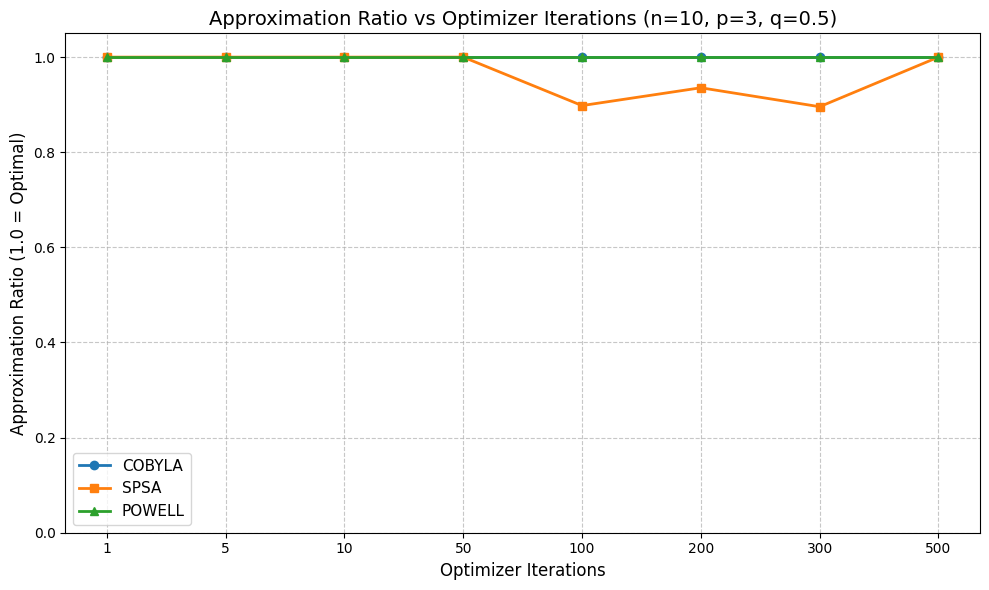

In [ ]:
# 1. Extract data for plotting
# Ensure iter_values_list is sorted (e.g., [1, 5, 10, 50...]) so the line doesn't zigzag
iter_values_list = sorted(list(results_by_iter.keys()))

cobyla_ratios = [results_by_iter[it]["COBYLA"]["ratio"] for it in iter_values_list]
spsa_ratios = [results_by_iter[it]["SPSA"]["ratio"] for it in iter_values_list]
powell_ratios = [results_by_iter[it]["POWELL"]["ratio"] for it in iter_values_list]

# 2. Plotting
plt.figure(figsize=(10, 6))

# Use an index for x-axis to keep spacing equal, but label them with the real values
x_positions = range(len(iter_values_list))

plt.plot(x_positions, cobyla_ratios, marker='o', label='COBYLA', linewidth=2)
plt.plot(x_positions, spsa_ratios, marker='s', label='SPSA', linewidth=2)
plt.plot(x_positions, powell_ratios, marker='^', label='POWELL', linewidth=2)

# Formatting
plt.xlabel("Optimizer Iterations", fontsize=12)
plt.ylabel("Approximation Ratio (1.0 = Optimal)", fontsize=12)
plt.title(f"Approximation Ratio vs Optimizer Iterations (n={n}, p={p}, q={q})", fontsize=14)

# Set the x-ticks to be the actual iteration numbers
plt.xticks(x_positions, iter_values_list)

plt.ylim(0, 1.05) # Keep y-axis standard
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

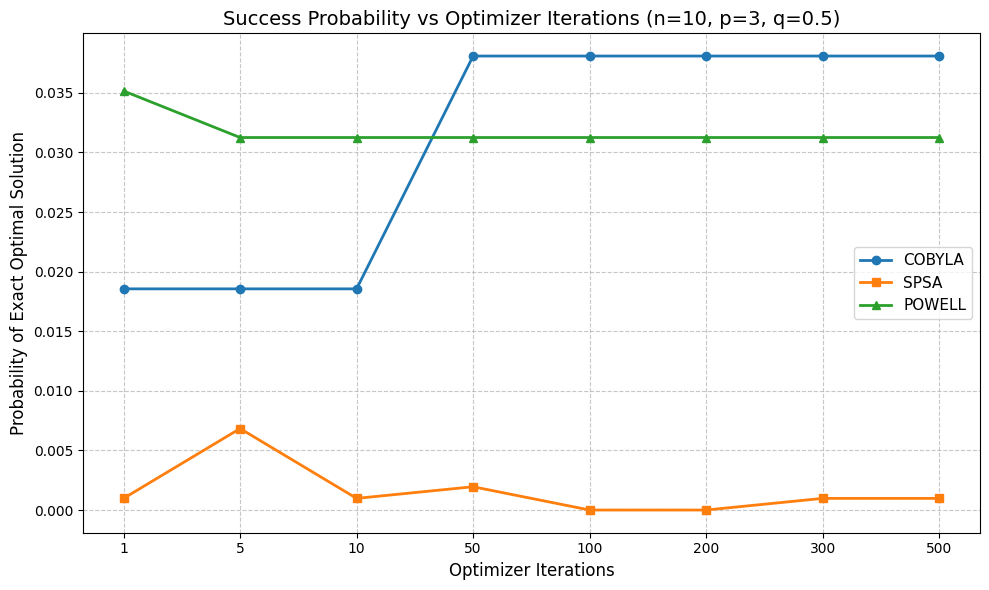

In [ ]:
# 1. Extract PROBABILITY data for plotting
# Ensure iter_values_list is sorted (e.g., [1, 5, 10, 50...])
iter_values_list = sorted(list(results_by_iter.keys()))

# Change ["ratio"] to ["success_prob"]
cobyla_probs = [results_by_iter[it]["COBYLA"]["success_prob"] for it in iter_values_list]
spsa_probs = [results_by_iter[it]["SPSA"]["success_prob"] for it in iter_values_list]
powell_probs = [results_by_iter[it]["POWELL"]["success_prob"] for it in iter_values_list]

# 2. Plotting
plt.figure(figsize=(10, 6))

# Use an index for x-axis to keep spacing equal, but label them with the real values
x_positions = range(len(iter_values_list))

plt.plot(x_positions, cobyla_probs, marker='o', label='COBYLA', linewidth=2)
plt.plot(x_positions, spsa_probs, marker='s', label='SPSA', linewidth=2)
plt.plot(x_positions, powell_probs, marker='^', label='POWELL', linewidth=2)

# Formatting
plt.xlabel("Optimizer Iterations", fontsize=12)
plt.ylabel("Probability of Exact Optimal Solution", fontsize=12) # <--- Updated Label
plt.title(f"Success Probability vs Optimizer Iterations (n={n}, p={p}, q={q})", fontsize=14) # <--- Updated Title

# Set the x-ticks to be the actual iteration numbers
plt.xticks(x_positions, iter_values_list)

#plt.ylim(0, 1.05) # Probability is always between 0 and 1
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Varying the depht of the circuit, p

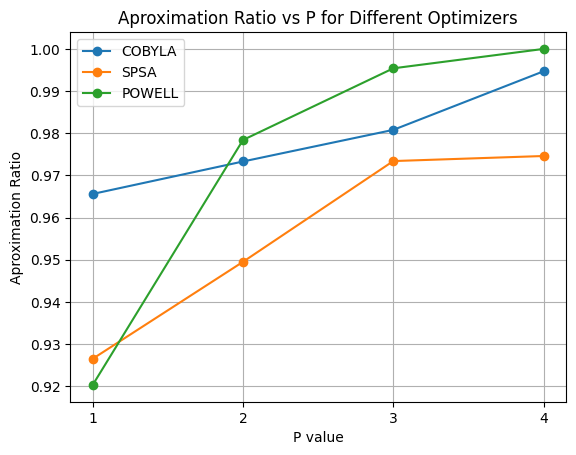

In [ ]:
p1 = [0.9656,0.9265,0.9203]
p2 = [0.9733,0.9495,0.9784]
p3 = [0.9808,0.9734,0.9954]
p4 = [0.9947,0.9746,1.0000]
datasets = [p1,p2,p3,p4]
indices = [1,2,3,4]
labels = ['COBYLA','SPSA','POWELL']
# Plot
plt.figure()

for i, label in enumerate(labels):
    # Tomar el valor correspondiente de cada p para este método
    values = [datasets[j][i] for j in range(len(indices))]
    plt.plot(indices, values, marker='o', label=label)

plt.xlabel("P value")
plt.ylabel("Aproximation Ratio")
plt.title("Aproximation Ratio vs P for Different Optimizers")
plt.legend()
plt.grid(True)
plt.xticks(indices)
plt.show()

Varying the penalty

In [ ]:
def run_penalty_analysis(qp_base, reps, mu, sigma, q, budget, penalty_range):
    """
    Varies the penalty parameter and analyzes how it affects QAOA performance.
    
    Args:
        qp_base (QuadraticProgram): The base portfolio optimization problem.
        reps (int): Number of QAOA circuit layers (depth p).
        mu (pd.Series or np.ndarray): Expected asset returns.
        sigma (pd.DataFrame or np.ndarray): Asset covariance matrix.
        q (float): Risk factor in the portfolio problem.
        budget (int): Budget constraint (number of assets to select).
        penalty_range (list): List of penalty values to test.
    
    Returns:
        dict: Results organized by penalty value, each containing:
            - "ratio" (float): Approximation ratio for the solution.
            - "success_prob" (float): Probability of finding the exact optimal solution.
            - "optimal_str" (str): The bitstring of the best solution found.
            - "optimal_val" (float): The objective value of the solution.
    """
    results_by_penalty = {}
    
    # Find the true optimal solution once (independent of penalty)
    exact_mes = NumPyMinimumEigensolver()
    exact_opt = MinimumEigenOptimizer(exact_mes)
    result_min = exact_opt.solve(qp_base)
    true_optimal_str = "".join(str(int(x)) for x in result_min.x)
    
    print(f"True Optimal Target: {true_optimal_str}")
    print(f"{'Penalty':<10} | {'Ratio':<10} | {'Success Prob':<15} | {'Best String':<15}")
    print("-" * 60)
    
    for penalty in penalty_range:
        algorithm_globals.random_seed = 1234
        
        sampler = Sampler(backend_options={"seed_simulator": 1234})
        optimizer = SPSA(maxiter=100)
        
        qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        result = qaoa.solve(qp_base)
        
        # Calculate Approximation Ratio
        ratio = get_aproximation_ratio(result, mu, sigma, q, budget)
        
        # Extract optimal string found
        found_optimal_str = "".join(str(int(x)) for x in result.x)
        
        # Extract Probabilities
        eigenstate = result.min_eigen_solver_result.eigenstate
        probabilities = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        # Check for the true optimal solution probability
        success_prob = probabilities.get(true_optimal_str, 0.0)
        if success_prob == 0.0:
            success_prob = probabilities.get(true_optimal_str[::-1], 0.0)
        
        # Store results
        results_by_penalty[penalty] = {
            "ratio": ratio,
            "success_prob": success_prob,
            "optimal_str": found_optimal_str,
            "optimal_val": result.fval
        }
        
        print(f"{penalty:<10.1f} | {ratio:<10.4f} | {success_prob:<15.4f} | {found_optimal_str:<15}")
    
    return results_by_penalty

In [ ]:
p = 3
n = 10
q = 0.5
budget = n//2

# Fetch and prepare data
tickers = get_famous_tickers(n)

mu, sigma, data = get_portfolio_data(tickers=tickers, start_date="2016-01-01", end_date="2016-12-30", num_assets=n)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program
qp_realdata, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q=q, budget=budget)

# Run penalty analysis
penalty_range = [1, 3, 6, 8, 10, 20, 50]
results_by_penalty = run_penalty_analysis(
    qp_base=qp_realdata,
    reps=p,
    mu=mu_normalized,
    sigma=sigma_normalized,
    q=q,
    budget=budget,
    penalty_range=penalty_range
)

C:\Users\andre\AppData\Local\Temp\ipykernel_17584\4110160887.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed


True Optimal Target: 1001011010
Penalty    | Ratio      | Success Prob    | Best String    
------------------------------------------------------------
1.0        | 1.0000     | 0.0010          | 1001011010     
3.0        | 0.9874     | 0.0000          | 0101011010     
6.0        | 1.0000     | 0.0098          | 1001011010     
8.0        | 1.0000     | 0.0342          | 1001011010     
10.0       | 0.8981     | 0.0000          | 1101011000     
20.0       | 0.9315     | 0.0000          | 0001111010     
50.0       | 0.7367     | 0.0000          | 0011010011     


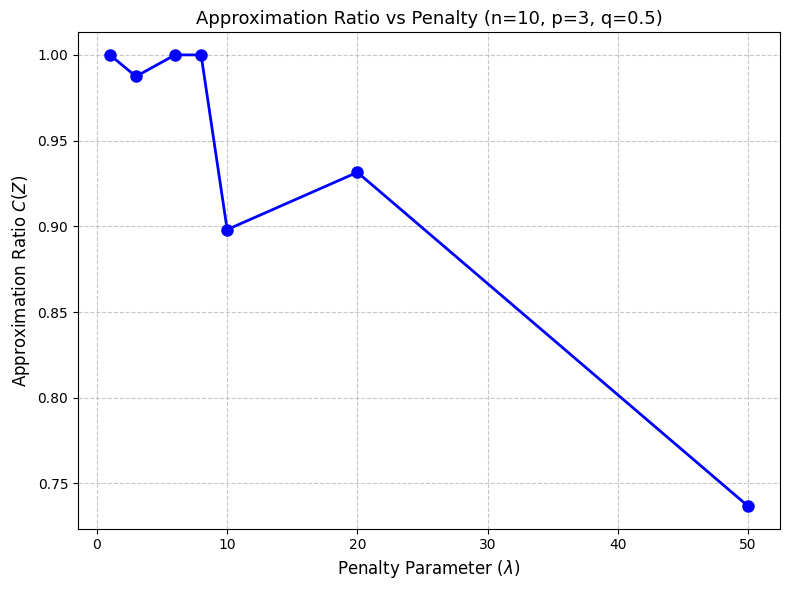

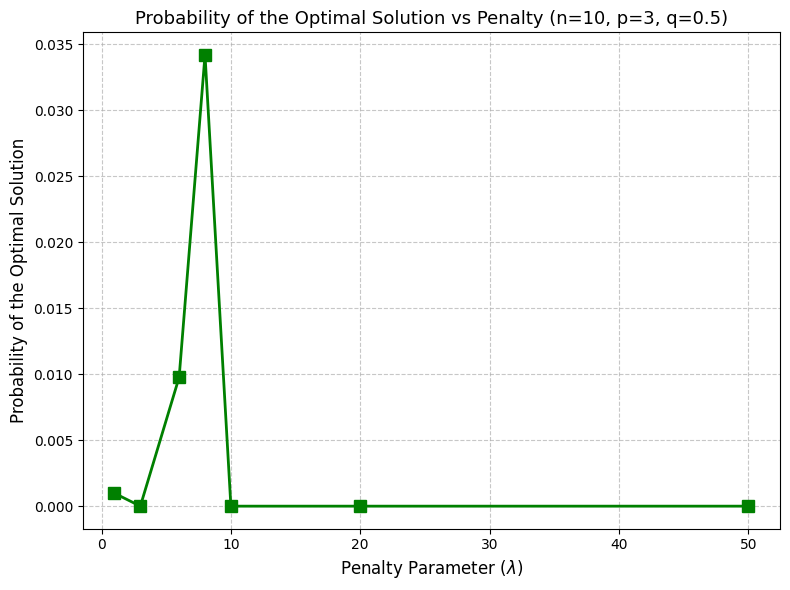

In [ ]:
# Extract data for plotting
penalties = sorted(results_by_penalty.keys())
ratios = [results_by_penalty[pen]["ratio"] for pen in penalties]
success_probs = [results_by_penalty[pen]["success_prob"] for pen in penalties]

# Aproximation Ratio vs Penalty
plt.figure(figsize=(8, 6))
plt.plot(penalties, ratios, marker='o', linewidth=2, markersize=8, color='blue')

# Updated Labels with LaTeX
plt.xlabel(r"Penalty Parameter ($\lambda$)", fontsize=12)
plt.ylabel(r"Approximation Ratio $C(Z)$", fontsize=12)
plt.title(f"Approximation Ratio vs Penalty (n={n}, p={p}, q={q})", fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Success Probability vs Penalty
plt.figure(figsize=(8, 6))
plt.plot(penalties, success_probs, marker='s', linewidth=2, markersize=8, color='green')

# Updated Labels with LaTeX
plt.xlabel(r"Penalty Parameter ($\lambda$)", fontsize=12)
plt.ylabel("Probability of the Optimal Solution", fontsize=12) # No standard symbol for probability, but you could use $P(Success)$
plt.title(f"Probability of the Optimal Solution vs Penalty (n={n}, p={p}, q={q})", fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Noise analysis

In [ ]:

def run_noise_analysis_prob(qp, penalty, reps, noise_range):
    """
    Runs QAOA with increasing noise and plots the PROBABILITY of finding the optimal solution.
    """
    success_probabilities = []
    
    # 1. First, find the "True" optimal string using the exact solver
    # We need this to know what to look for in the noisy results
    from qiskit_algorithms import NumPyMinimumEigensolver
    exact_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
    # Convert [1. 0. 1. 0.] -> "1010" (No reversal needed for comparison if consistent)
    # Note: Qiskit probabilities are often Little Endian (reversed). 
    # Let's rely on the exact solver's string format.
    true_optimal_str = "".join(str(int(x)) for x in exact_result.x)
    
    print(f"True Optimal Target: {true_optimal_str}")
    print("-" * 60)
    print(f"{'Noise Prob':<15} | {'Success Prob':<15} | {'Top Found'}")

    for prob in noise_range:
        algorithm_globals.random_seed = 1234
        
        #Noise Model Setup
        noise_model = NoiseModel()
        error_1q = depolarizing_error(prob, 1)
        error_2q = depolarizing_error(prob, 2)
        noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])
        noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
        
        #Run QAOA

        # This forces the random number generator for the measurement shots to be identical every time.
        noisy_sampler = Sampler(
            backend_options={
                "noise_model": noise_model,
                "seed_simulator": 1234
            }
        )
        optimizer = POWELL(maxiter=100)
        qaoa_mes = QAOA(sampler=noisy_sampler, optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        
        result = qaoa.solve(qp)
        
        # --- EXTRACT PROBABILITY ---
        eigenstate = result.min_eigen_solver_result.eigenstate
        probs = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        # We need to handle the bitstring reversal (Endianness)
        # Qiskit results are often right-to-left. 
        # Check both the string and its reverse to be safe, or stick to one convention.
        # Here we check if the true_optimal_str (or its reverse) is in the keys.
        
        # Try direct match first
        current_prob = probs.get(true_optimal_str, 0.0)
        
        # If 0, try checking the reverse key (common issue with Qiskit/Numpy conversion)
        if current_prob == 0.0:
            current_prob = probs.get(true_optimal_str[::-1], 0.0)
            
        success_probabilities.append(current_prob)
        
        # Find what the most probable result actually was for logging
        top_found = max(probs, key=probs.get)
        
        print(f"{prob:<15.4f} | {current_prob:<15.4f} | {top_found}")

    #Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(noise_range, success_probabilities, marker='o', color='red', linewidth=2)
    plt.title(f"QAOA Robustness: Probability of Finding Optimal 'n = {n_noise}' 'budget = {budget_noise}'", fontsize=14)
    plt.xlabel("Depolarizing Noise Probability", fontsize=12)
    plt.ylabel("Probability of Optimal Solution", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_17584\4110160887.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed

Selected Tickers for Noise Analysis: ['JNJ', 'COST', 'V', 'INTC']
True Optimal Target: 0110
------------------------------------------------------------
Noise Prob      | Success Prob    | Top Found


0.0000          | 0.1846          | 0100
0.0100          | 0.4180          | 0110
0.0500          | 0.0566          | 1100
0.1000          | 0.0684          | 0001
0.2000          | 0.0635          | 0001
0.3000          | 0.0635          | 0001
0.5000          | 0.0635          | 0001
0.6000          | 0.0635          | 0001
0.7000          | 0.0635          | 0001
0.8000          | 0.0635          | 0001
0.9000          | 0.0635          | 0001
1.0000          | 0.0635          | 0001


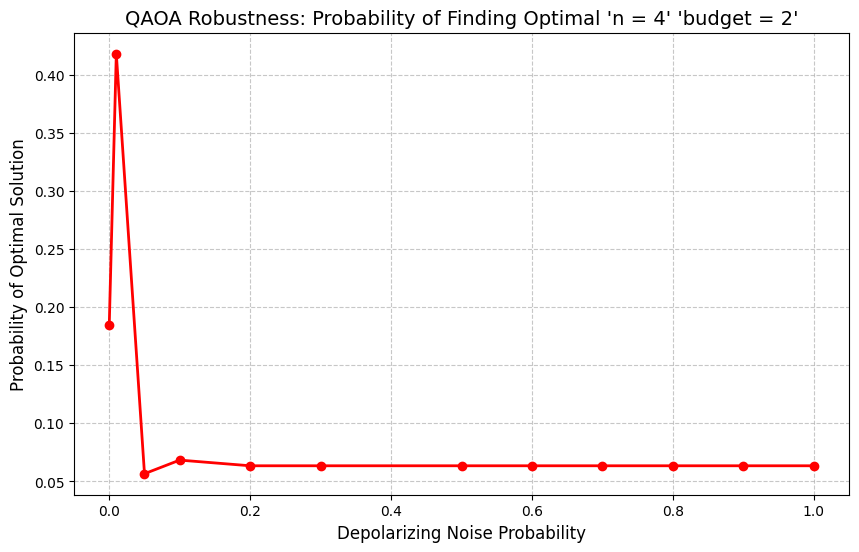

In [ ]:
# Noise Analysis Parameters (defined again because of simulation time)
iter_noise=200
p_noise = 2
n_noise = 4
q_noise = 0.5
budget_noise = n_noise//2
penalty_noise = n_noise

# Fetch and prepare data for noise analysis
tickers_noise = get_famous_tickers(n_noise)
print("Selected Tickers for Noise Analysis:", tickers_noise)
mu, sigma, data = get_portfolio_data(tickers=tickers_noise, start_date="2016-01-01", end_date="2016-12-30", num_assets=n_noise)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program for noise analysis
qp_noise, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q_noise, budget_noise)

# Run it
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
run_noise_analysis_prob(qp_noise, penalty_noise, reps=p_noise, noise_range=noise_levels)